## 데이터 읽어오기

In [1]:
import glob
import os, re
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

# txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        # read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. 
        # splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw = f.read().splitlines()
        # extend() : 리스트함수로 추가적인 내용을 연장 한다.
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [2]:
for i in range(20):
    print(i, ': ', raw_corpus[i])

0 :  
1 :  
2 :  [Spoken Intro:]
3 :  You ever want something 
4 :  that you know you shouldn't have 
5 :  The more you know you shouldn't have it, 
6 :  The more you want it 
7 :  And then one day you get it, 
8 :  It's so good too 
9 :  But it's just like my girl 
10 :  When she's around me 
11 :  I just feel so good, so good 
12 :  But right now I just feel cold, so cold 
13 :  Right down to my bones 
14 :  'Cause ooh... 
15 :  Ain't no sunshine when she's gone 
16 :  It's not warm when she's away 
17 :  Ain't no sunshine when she's gone 
18 :  And she's always gone too long 
19 :  Anytime she goes away 


In [3]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과
# 그 문장읜 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    # 길리가 0인 문장은 건너뜁니다.
    if len(sentence) == 0: continue
    # 문장의 끝이 ] 인 문장은 건너뜁니다.
    if sentence[-1] == "]": continue
    # 문장 20개만 확인.
    if idx > 19: break
        
    print(sentence)

You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 
It's not warm when she's away 
Ain't no sunshine when she's gone 
And she's always gone too long 
Anytime she goes away 


## 데이터 정제

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+'," ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [5]:
# 필터링 잘 적용됬는지 확인.
print(preprocess_sentence("This @_is ;;;sample          sentence."))

<start> this is sample sentence . <end>


In [6]:
# 필터링된 문장 저장.
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다.
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제 하고 저장합니다.
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

In [7]:
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

## 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [8]:
def tokenize(corpus):
    # 15,000 단어를 기억할 수 있는 tokenizer를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, filters=' ', oov_token="<unk>")
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성.
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다.
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=20)
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fd1e42e0a90>


In [9]:
# 생성된 텐서 데이터 확인.
print(tensor[:3, :10])

[[   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1536   15   76    3    0]
 [   2    6   98    7   34    7 1536   15   76   11]]


In [10]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형태로 반환
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [11]:
# tensor에서 마지막 토큰을 잘라서 소스 문장을 생성, 해당 토큰은 <end>가 아니라 <pad>일 가능성 높음.
src_input = tensor[:, :-1]
# tenor에서 <start>를 잘라내서 타겟 문장을 생성.
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


훈련 데이터와 평가데이터로 분리하기!

In [12]:
from sklearn.model_selection import train_test_split
# 소스문장을 train으로 타겟 문장을 val로.
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, random_state=2023, test_size= 0.2)

In [13]:
print(enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape)

(139790, 19) (34948, 19) (139790, 19) (34948, 19)


In [14]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 15000개와, 여기 포함되지 않은 0:<pad>를 포함하여 15001개
# tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
# tokenize() 함수에서 num_words를 15000개로 선언했기 때문에, tokenizer.num_words의 값은 15000개
VOCAB_SIZE = tokenizer.num_words + 1

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder = True)
train_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

## Step 5. 인공지능 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.

model.fit(dataset, epochs=30)
하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질 수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만,
# 데이터의 양이 적으면 긍정적인 결과가 나오지 않을 수 있다.
# 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
embedding_size = 512
hidden_size = 2048
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [18]:
# 데이터셋에서 데이터 한 배치만 가져와서 모델에 넣어서 확인.
for src_sample, tgt_sample in train_dataset.take(1): break

lyricist(src_sample)

<tf.Tensor: shape=(256, 19, 15001), dtype=float32, numpy=
array([[[ 2.63942820e-05, -8.18772824e-05, -9.79509859e-05, ...,
         -9.91337220e-05,  8.78163264e-05,  1.43919518e-04],
        [ 4.57413145e-04, -2.39000467e-04, -1.94939930e-04, ...,
         -3.82338214e-04,  8.75895275e-05,  3.94405288e-06],
        [ 5.61957771e-04, -5.75165730e-04, -5.69165044e-04, ...,
         -4.62788768e-04,  3.71017697e-04, -9.13665863e-05],
        ...,
        [-5.40264184e-04, -1.55906717e-03, -9.80683952e-04, ...,
         -1.47486699e-03, -1.78612221e-03, -2.16201297e-03],
        [-5.89596399e-04, -1.48225785e-03, -9.18462407e-04, ...,
         -1.48213841e-03, -2.21425015e-03, -2.22714082e-03],
        [-6.46775705e-04, -1.41686795e-03, -8.59385065e-04, ...,
         -1.47831161e-03, -2.60963780e-03, -2.25203903e-03]],

       [[ 2.63942820e-05, -8.18772824e-05, -9.79509859e-05, ...,
         -9.91337220e-05,  8.78163264e-05,  1.43919518e-04],
        [-2.07133315e-04, -4.04570106e-04, -1

In [19]:
# 모델 구조 확인.
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7680512   
_________________________________________________________________
lstm (LSTM)                  multiple                  20979712  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  30737049  
Total params: 92,959,897
Trainable params: 92,959,897
Non-trainable params: 0
_________________________________________________________________


In [20]:
# optimizer로는 사용빈도가 높은 Adam으로 선택.
optimizer = tf.keras.optimizers.Adam()

# 훈련 데이터의 라벨이 정수의 형태로 제공될 때, 사용하는 손실함수.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# from_logits 의 기본값은 False. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려줌.
# 즉, softmax 함수가 적용되지 않았다는걸 의미.
# reduction 의 기본값은 SUM. 각자 나오는 값의 반환을 원할 때, None을 사용.

lyricist.compile(loss=loss, optimizer=optimizer)
history = lyricist.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
546/546 [==============================] - 398s 724ms/step - loss: 2.8304 - val_loss: 2.4917
Epoch 2/10
546/546 [==============================] - 394s 722ms/step - loss: 2.3564 - val_loss: 2.2918
Epoch 3/10
546/546 [==============================] - 395s 722ms/step - loss: 2.1332 - val_loss: 2.1556
Epoch 4/10
546/546 [==============================] - 395s 723ms/step - loss: 1.9244 - val_loss: 2.0528
Epoch 5/10
546/546 [==============================] - 396s 725ms/step - loss: 1.7230 - val_loss: 1.9710
Epoch 6/10
546/546 [==============================] - 396s 724ms/step - loss: 1.5315 - val_loss: 1.9104
Epoch 7/10
546/546 [==============================] - 396s 725ms/step - loss: 1.3527 - val_loss: 1.8644
Epoch 8/10
546/546 [==============================] - 395s 723ms/step - loss: 1.1902 - val_loss: 1.8372
Epoch 9/10
546/546 [==============================] - 395s 724ms/step - loss: 1.0479 - val_loss: 1.8276
Epoch 10/10
546/546 [==============================] - 396s 725m

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다.(한 epoch 당 3 분 이상) 여유를 가지고 작업하시면 좋아요 :)

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!



In [28]:
# 문장생성 함수 정의
# 모델에게 시작 문장을 전달하면 시작 문장을 바탕으로 작문을 진행.
# 시작 문자열을 init_sentence 로 받으며, 디폴트 값은 <start> 를 받음.
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해, 입력 받은 init_sentence로 텐서로 변환.
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장을 생성
    # 1. 입력받은 문장의 텐서를 입력.
    # 2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냄.
    # 3. 2에서 예측된 word index를 문장 뒤에 붙임.
    # 4. 모델이 <end>를 예측햇거나, max_len에 도달했다면 문장 생성을 마침.
    # 루프를 돌면서 init_sentence에 단어를 하나씩 생성
    while True:
        # 1
        predict = model(test_tensor)
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
    
    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    # 모델이 생성한 문장을 반환.
    return generated

In [29]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you <end> '

In [30]:
generate_text(lyricist, tokenizer, init_sentence="<start> i do", max_len=20)

'<start> i do not like <end> '

In [31]:
generate_text(lyricist, tokenizer, init_sentence="<start> i have", max_len=20)

'<start> i have a little husband , <end> '

In [32]:
generate_text(lyricist, tokenizer, init_sentence="<start> i want", max_len=20)

'<start> i want to get in the zone if you really want to party <end> '

In [33]:
generate_text(lyricist, tokenizer, init_sentence="<start> your", max_len=20)

'<start> your love is fadin <end> '

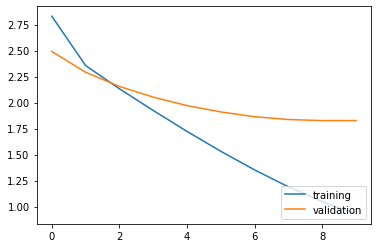

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()